# Dubins 2D Aircraft Rejoin Example

This Jupyter notebook demonstrates a multi-agent task scenario with control system analysis framework (CSAF), where a group of Dubins aircraft attempt to rejoin in formation and collectively fly at a specific heading angle. Dubins aircraft presents a dynamically simple 2D aircraft model, taken from the [AerospaceRL repository on GitHub](https://github.com/act3-ace/aerospaceRL). The state space is 3D, being two position coordinates $(x,y)$
and a heading angle $\theta$. The control action simply is to apply a heading angular rate $\dot \theta$ while maintaining constant velocity
(no throttle). The update equation is

$$
  \dot{\mathbf x} = \begin{bmatrix}
v \cos (x_2) \\
v \sin (x_2) \\
u \\
\end{bmatrix},
$$

where $\mathbf{x} = (x, y, \theta)$, and $v$ is some fixed airspeed parameter.


## Controller Design

A lateral rejoin task is specified: given **n** planes at different orientations, produce **n** maneuver sequences that allow them to be no further
than some terminal length apart $r_l$ and at some terminal heading angle $\theta_t$. Given that the only control surface that can be affected is angular
rate, the following control scheme is formulated,

1.  Associate each plane with neighbors that should be considered in collision avoidance; construct a graph $\mathcal G = (\mathcal P, \mathcal C)$ with vertices of planes $\mathcal P$ and edges of neighbors $\mathcal C$. In this case, a simple $k$-neighbors was done,
    with $k=1$; solve only for the nearest neighbor. This method can be extended to different graph constructions, by
    appropriately weighting the graph edges inversely to the distances between nodes via a weighted adjacency matrix.
2.  Solve for the angle that will cause a plane $s_i$ and its nearest neighbor $s_j$ to approach one another the fastest,
$$
\theta_{i}(s_i, s_j) = \operatorname{atan2}(x_{j1} -x_{i1}, x_{j0} - x_{i0}).
$$
3.  Linearly combine the angle $\theta_i$ and the terminal heading angle $\theta_t$.
    Apply some weight that is a function of the distance between the aircraft $r$, $w: \overline{\mathbb R^-}  \rightarrow [0, 1]$,
$$
\theta_c(s_i) = w(r(s_i, s_j)) \theta_t + (1-w(r(s_i, s_j))) \theta_j.
$$
    In this example,
$$
w(r) = \exp\left( -\frac{(r-r_l)^2}{\tau} \right),
$$
    where $r_l$ is the desired final distance between aircraft, and $\tau$ is a hyperparameter characterizing how soon to apply the collision avoidance correction.
4.  This solves for the desired heading angle of the aircraft. As the heading angular rate is the input, control the position quantity via a proportional controller,
$$
u = k_p (\theta_c - \theta).
$$
    
<div>
<img src="img/dubins_rejoin_diag.png" width="500"/>
</div>

In [1]:
# if running locally
import sys
sys.path.append("..")

# import csaf and Dubins rejoin example model
import csaf
import csaf.utils as csafutils
import csaf_examples.rejoin as rejoin

# other imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


## Configuration

The Dubins system can be created via the `generate_dubins_system` function by passing in a list of vehicles' initial states. A controller is created dynamically to support the number of vehicles specified with the states list. This system component topology can be viewed via the `view_block_diagram` utility function.

In [2]:
j_states = [[0, 0, np.deg2rad(45)],
              [-5, -10, np.deg2rad(-30)],
            [-3, -15, np.deg2rad(90)],
            [0, -20, np.deg2rad(0)]]

system = rejoin.generate_dubins_system(j_states)

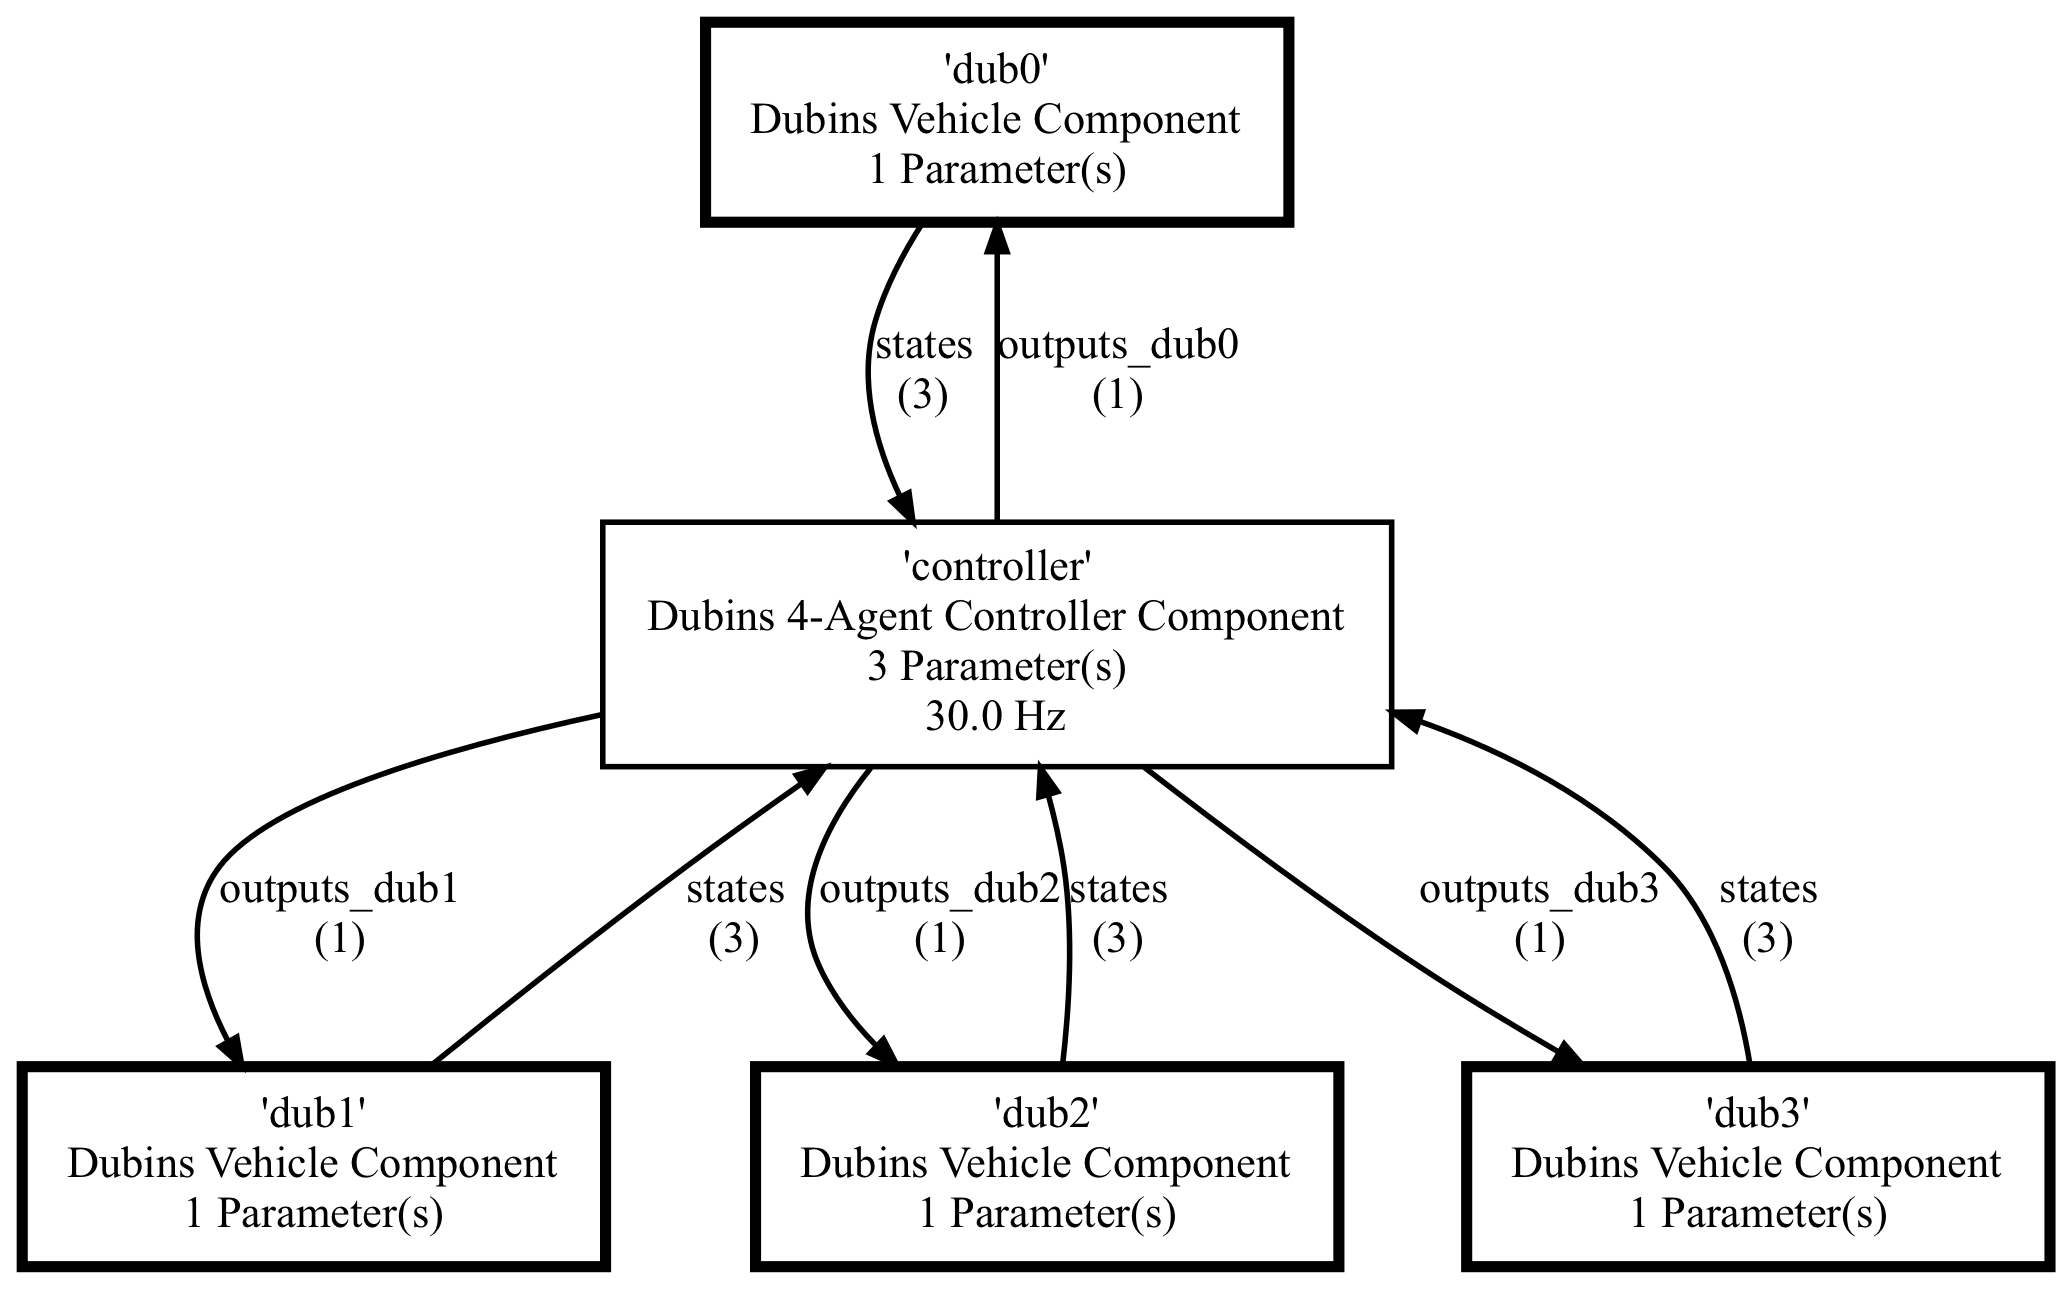

In [3]:
# view the system
csafutils.view_block_diagram(system, ipython_notebook=True)

## Simulation

After configuration, the CSAF system is simulated via the method `System.simulate_tspan`. The returned traces `trajs` capture the trajectories of each agent as the controller applies the angular rate.

In [4]:
# run simulation
trajs = system.simulate_tspan((0.0, 25.0))

In [5]:
# pack states into convenient data structure
states = [np.array(trajs['dub'+str(idx)].states) for idx in range(len(j_states))]

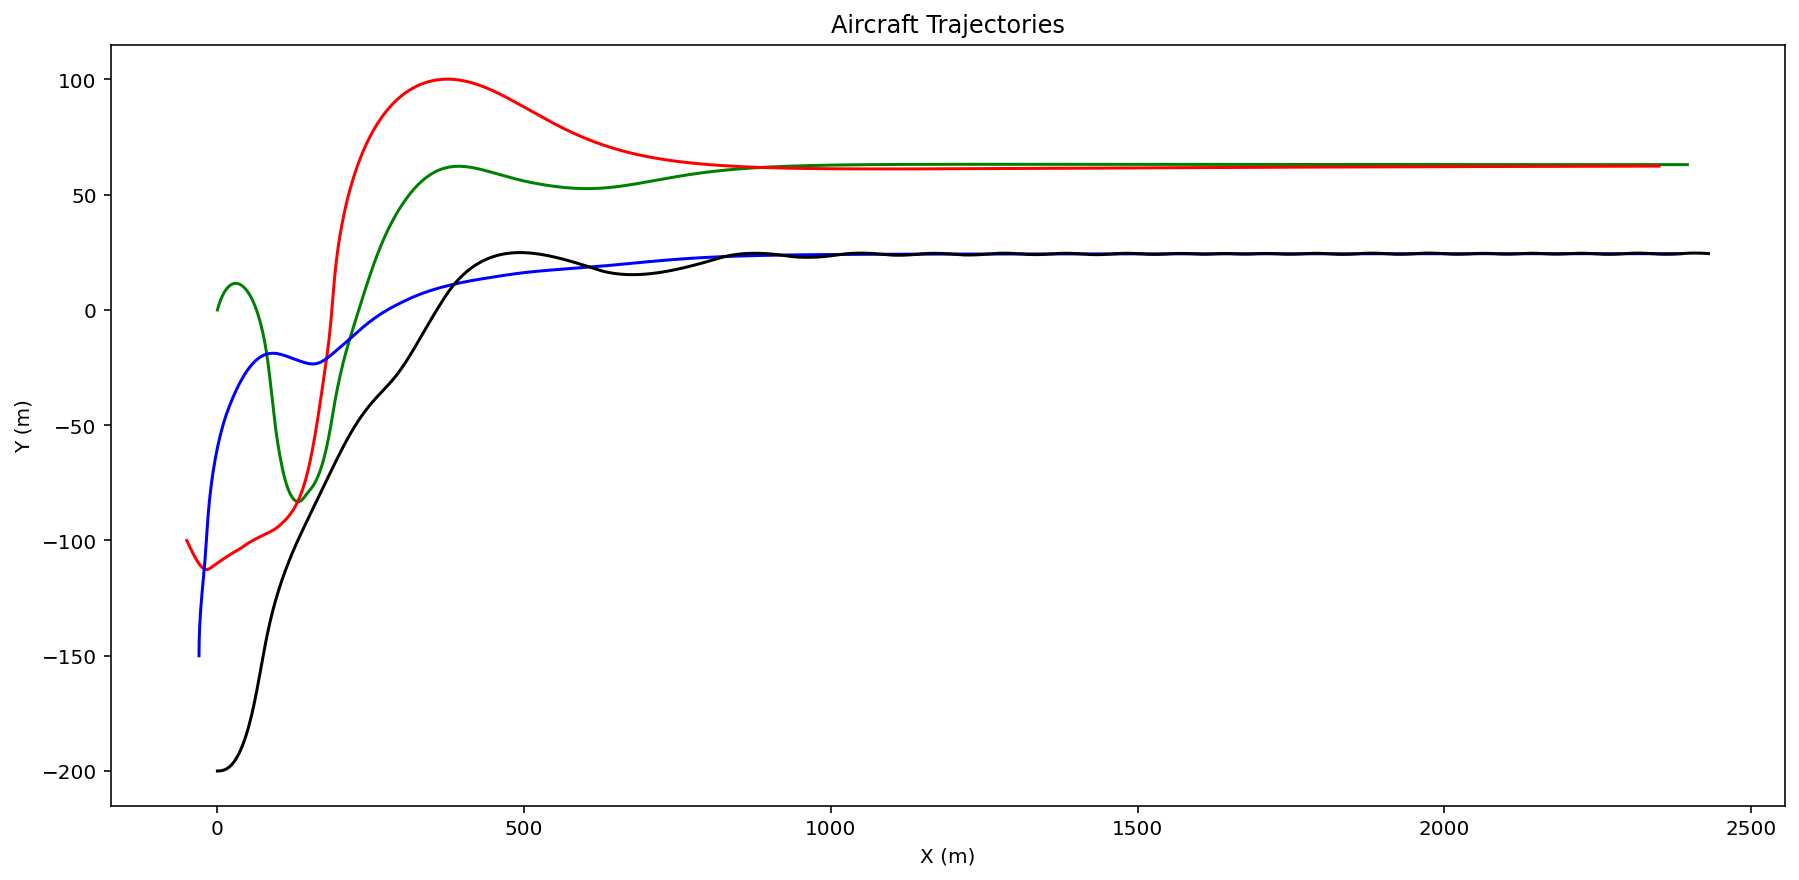

In [6]:
# show aircraft trajectories
cs = ['g', 'r', 'b', 'k']
fig, ax = plt.subplots(figsize=(15, 7))
for idx in range(4):
    plt.plot(*states[idx][:, :2].T*10, c=cs[idx])
plt.title("Aircraft Trajectories")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.show()

## Animation

When running the Jupyter notebook, animation is available to view the trajectories as a movie. Uncomment the following code and run.

In [7]:
# uncomment this to get an animation
"""
%matplotlib notebook
ani = rejoin.plot_air_anim(states)
from IPython.display import HTML
HTML(ani.to_jshtml())
"""

'\n%matplotlib notebook\nani = rejoin.plot_air_anim(states)\nfrom IPython.display import HTML\nHTML(ani.to_jshtml())\n'